In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import date, timedelta
from seaborn import lineplot
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pingouin import partial_corr

## Úvod

V tomto projektu analyzuji vývoj počtů v koloniích tučňáků (konkrétně tučňáků kroužkových, oslích a uzdičkových) na ostrově Signy. Pro každou z těchto řad vyberu vhodný ARIMA model a zanalyzuji, zda spolu řady korelují.

Zdroj dat: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5082682/

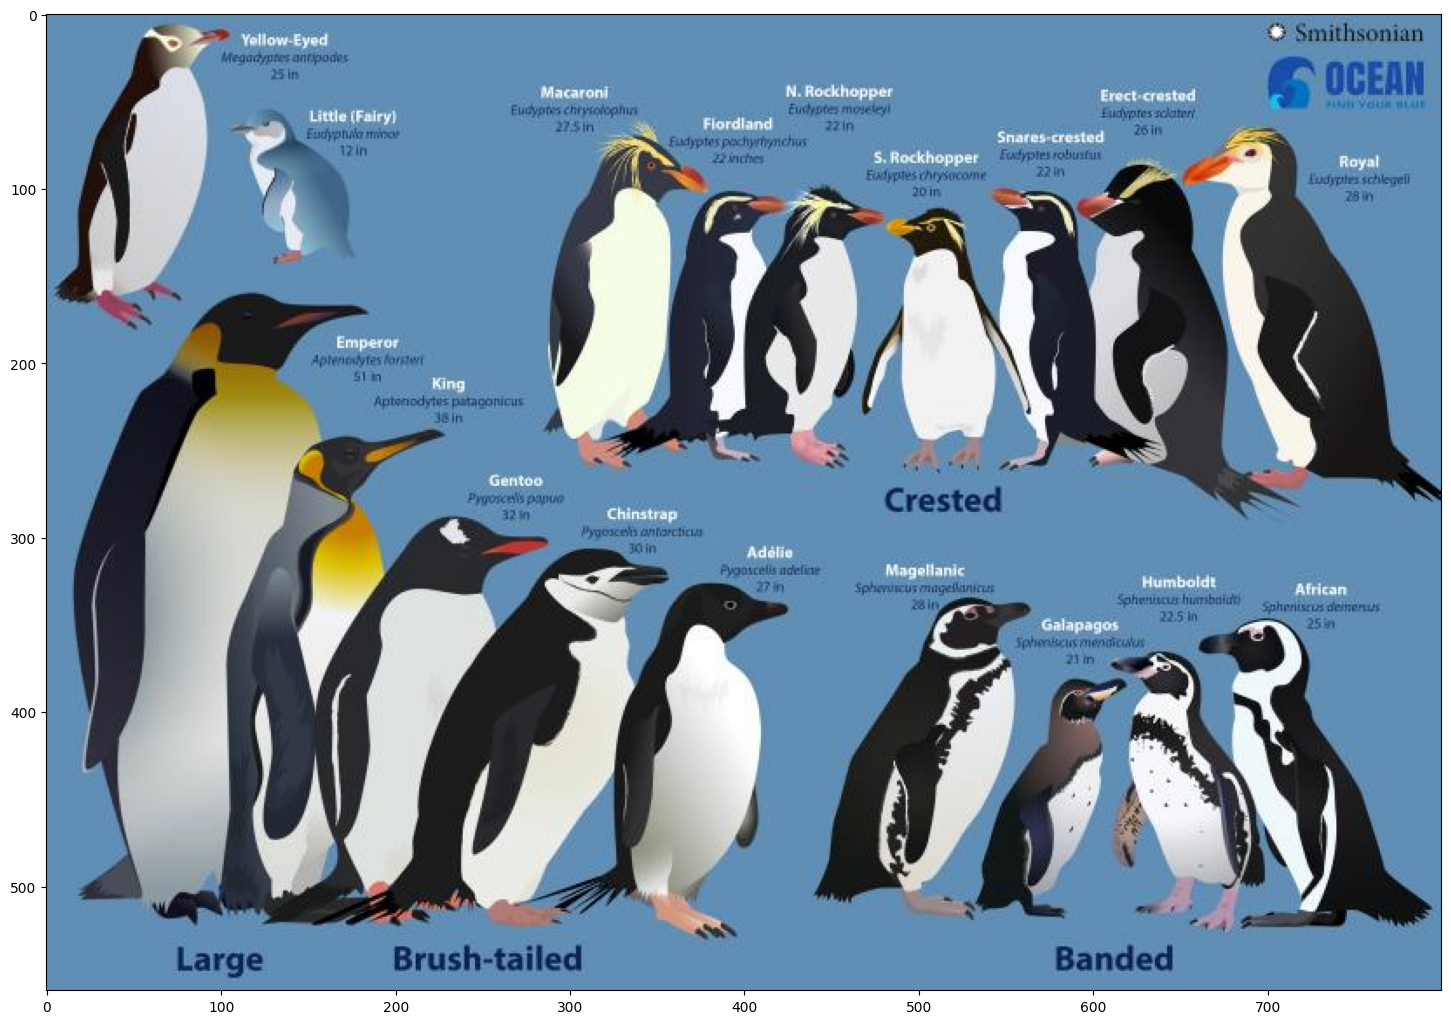

In [2]:
img = mpimg.imread('penguingraphic.jpg')
plt.figure(figsize=(18, 18))
plt.imshow(img)

In [3]:
df = pd.DataFrame(pd.read_csv("signy_island_penguin_pairs.csv", delimiter=";"))
df.head()

,Season,Adélie breeding pairs,Date of pair count,Chinstrap breeding pairs,Date of pair count.1,Gentoo breeding pairs,Date of pair count.2
0,1978/79,873,5 Dec.1978,2050,14 Dec. 1978,370,26 Nov. 1978
1,1979/80,2269,16 Nov. 1979,2253,08 Dec. 1979,303,19 Nov. 1979
2,1980/81,1726,11 Nov. 1980,1809,29 Dec. 1980,330,11 Nov. 1980
3,1981/82,1831,22 Nov. 1981,2250,25 Dec. 1981,341,22 Nov. 1981
4,1982/83,2631,19 Nov. 1982,2334,04 Dec. 1982,299,21 Nov. 1982


### Předzpracování
- Převod datumů na formát datetime
- Doplnění chybějících údajů průměry (sezóny 1997/98 a 2010/11)

In [4]:
df.loc[-1] = ["1997/98", 
              (df.loc[df['Season'] == "1996/97"]["Adélie breeding pairs"].iloc[0] + df.loc[df['Season'] == "1998/99"]["Adélie breeding pairs"].iloc[0])/2, 
              "1997-11-10", 
              (df.loc[df['Season'] == "1996/97"]["Chinstrap breeding pairs"].iloc[0] + df.loc[df['Season'] == "1998/99"]["Chinstrap breeding pairs"].iloc[0])/2, 
              "1997-12-10",  
              (df.loc[df['Season'] == "1996/97"]["Gentoo breeding pairs"].iloc[0] + df.loc[df['Season'] == "1998/99"]["Gentoo breeding pairs"].iloc[0])/2, 
              "1997-11-25"
             ]
df.index = df.index + 1
df = df.sort_values(by='Season', ascending=True, ignore_index = True)
df.loc[-1] = ["2010/11", 
              (df.loc[df['Season'] == "2009/10"]["Adélie breeding pairs"].iloc[0] + df.loc[df['Season'] == "2011/12"]["Adélie breeding pairs"].iloc[0])/2, 
              "2010-11-10", 
              (df.loc[df['Season'] == "2009/10"]["Chinstrap breeding pairs"].iloc[0] + df.loc[df['Season'] == "2011/12"]["Chinstrap breeding pairs"].iloc[0])/2, 
              "2010-12-10",  
              (df.loc[df['Season'] == "2009/10"]["Gentoo breeding pairs"].iloc[0] + df.loc[df['Season'] == "2011/12"]["Gentoo breeding pairs"].iloc[0])/2, 
              "2010-11-25"
             ]
df.index = df.index + 1
df = df.sort_values(by='Season', ascending=True, ignore_index = True)
df['year']= pd.DatetimeIndex(pd.to_datetime(df['Date of pair count'])).year
df = df.drop(columns=['Date of pair count', 'Date of pair count.1', 'Date of pair count.2', 'Season'])
df = df.set_index('year')

<AxesSubplot:xlabel='year'>

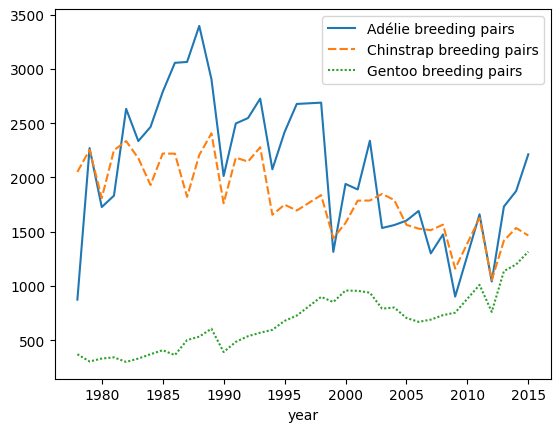

In [5]:
lineplot(df)

## Řada 1 - Tučňák kroužkový (Adélie)

- Na řadě nepozoruji ani trend, ani sezónnost

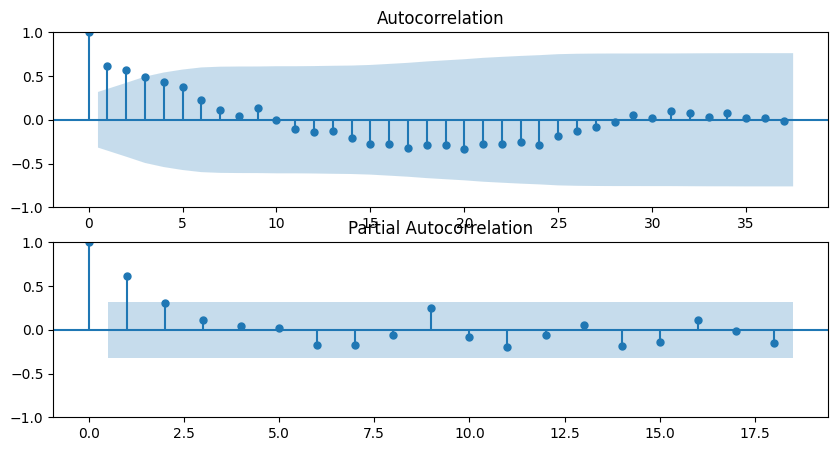

In [6]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Adélie breeding pairs'], lags=37, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Adélie breeding pairs'], lags=18, method='ywm', ax=ax2)

In [7]:
stepwise_fit = pm.auto_arima(df['Adélie breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='bic',
                             stepwise=True) 
stepwise_fit = pm.auto_arima(df['Adélie breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='aic',
                             stepwise=True) 

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=577.207, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=575.321, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=574.616, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=573.616, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=571.888, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.157 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=570.763, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=572.099, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=569.783, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=568.783, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=570.277, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=570.756, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=566.965, Time=0.02 

Nejvhodnější bude dle BIC ARIMA(0,1,0) - náhodná procházka, či podle AIC ARIMA(0,1,1) - jednoduché exponenciální vyhlazování. Zkusím obě možnosti a porovnám výsledky.

In [8]:
model1 = ARIMA(df['Adélie breeding pairs'], order=(0,1,0), trend='n')
result1 = model1.fit()
print(result1.summary())
model2 = ARIMA(df['Adélie breeding pairs'], order=(0,1,1), trend='n')
result2 = model2.fit()
print(result2.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Adélie breeding pairs   No. Observations:                   38
Model:                    ARIMA(0, 1, 0)   Log Likelihood                -284.138
Date:                   Sat, 17 Dec 2022   AIC                            570.277
Time:                           22:05:05   BIC                            571.888
Sample:                                0   HQIC                           570.845
                                    - 38                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.738e+05   5.57e+04      4.915      0.000    1.65e+05    3.83e+05
Ljung-Box (L1) (Q):                   4.36   Jarque-Bera (JB):                 1.38
Prob(Q):               

C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

Analýza výsledků:

ARIMA(0,1,0):
- Ljung-Box test - p-hodnota = 0.04 < 0.05 --> rezidua nejsou nezávislé (zamítáme nulovou hypotézu)
- Heteroskedasticita - p-hodnota = 0.14 --> nezamítáme nulovou hypotézu
- Jarque-Bera test - p-hodnota 0.5 --> nezamítáme nulovou hypotézu


ARIMA(0,1,1):
- L1 test - p-hodnota = 0.89 --> nezamítáme nulovou hypotézu
- Heteroskedasticita - p-hodnota = 0.09 --> nezamítáme nulovou hypotézu 
- Jarque-Bera test - p-hodnota = 0.08 --> nezamítáme nulovou hypotézu


Porovnání MSE a MAE:

In [9]:
print('ARIMA(0,1,0) MSE: ' + str(result1.mse))
print('ARIMA(0,1,1) MSE: ' + str(result2.mse))
print('ARIMA(0,1,0) MAE: ' + str(result1.mae))
print('ARIMA(0,1,1) MAE: ' + str(result2.mae))

ARIMA(0,1,0) MSE: 286863.36842105264
ARIMA(0,1,1) MSE: 257301.48039163827
ARIMA(0,1,0) MAE: 410.1578947368421
ARIMA(0,1,1) MAE: 366.53698198997677


Na základě výsledků MAE, MSE a Ljung-Box testu volím jako vhodnější model ARIMA(0,1,1). Model náhodné procházky by také navíc žádnou zajímavou predikci neposkytl. Tento model můžu dále diagnostikovat:

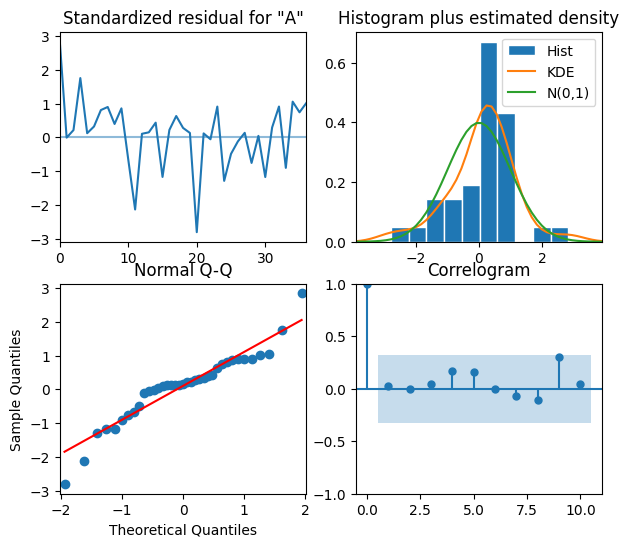

In [10]:
result2.plot_diagnostics(figsize=(7,6))
plt.show()

- Vývoj standardizovaných reziduí nenaznačuje žádný modelovatelný vývoj
- KDE se blíží normálnímu rozdělení
- Kvantily neleží zcela na diagonále, avšak ve většině případů se jí blíží
- Korelace je nízká

Predikce:

<AxesSubplot:xlabel='year'>

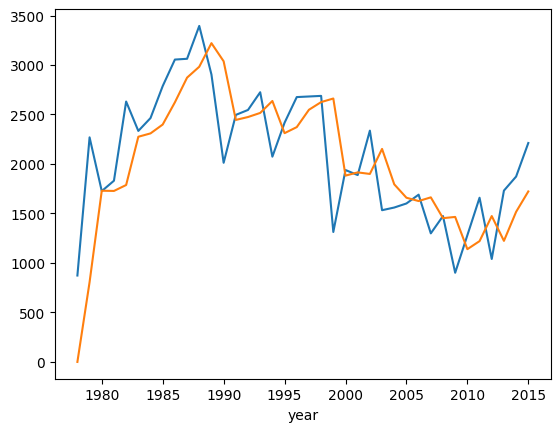

In [11]:
prediction = result2.get_prediction()
result2.data.orig_endog.plot(label='data', fig=fig)
prediction.predicted_mean.plot(fig=fig)

Určím vhodné modely i pro zbylé časové řady. Jelikož se jedná o vývoje populace velmi blízkých druhů, dalo by se na první dojem předpokládat, že by se i populace mohly vyvíjet podobně a tedy by pro budoucí predikce mohl být použit stejný model. Tvar řad však naznačuje, že tomu tak nemusí být.

### 2. řada - Tučňák oslí (Gentoo)

Ačkoliv to neplatí pro všechny body časové řady, zdá se, že by se v řadě mohl vyskytovat trend.

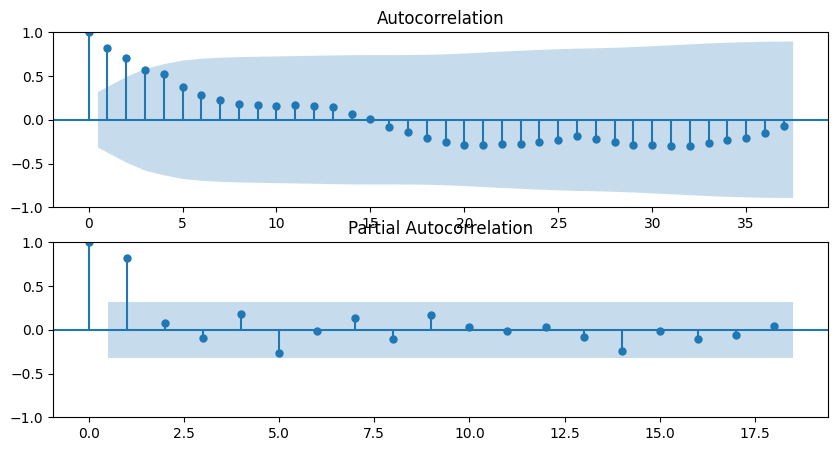

In [12]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Gentoo breeding pairs'], lags=37, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Gentoo breeding pairs'], lags=18, method='ywm', ax=ax2)

ACF i PACF se velmi liší od předchozí řady, je tedy možné, že bude vhodnější jiný model než ARIMA(0,1,1).

In [13]:
stepwise_fit = pm.auto_arima(df['Gentoo breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='bic',
                             stepwise=True) 
stepwise_fit = pm.auto_arima(df['Gentoo breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='aic',
                             stepwise=True) 

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=459.585, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=455.905, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=456.158, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=456.867, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=454.461, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.111 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=453.141, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=452.683, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=451.325, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=452.035, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=452.850, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=453.105, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=454.852, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=452.982, Time=0

BIC opět nabízí náhodnou procházku, avšak AIC naznačuje vhodnost použití modelu s AR částí, ARIMA(1,1,0). Vyzkouším možnosti jak s lineárním trendem tak bez trendu.

In [14]:
model1 = ARIMA(df['Gentoo breeding pairs'], order=(0,1,0), trend='n')
result1 = model1.fit()
print(result1.summary())
model2 = ARIMA(df['Gentoo breeding pairs'], order=(1,1,0), trend='n')
result2 = model2.fit()
print(result2.summary())
model3 = ARIMA(df['Gentoo breeding pairs'], order=(0,1,0), trend='t')
result3 = model3.fit()
print(result3.summary())
model4 = ARIMA(df['Gentoo breeding pairs'], order=(1,1,0), trend='t')
result4 = model4.fit()
print(result4.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Gentoo breeding pairs   No. Observations:                   38
Model:                    ARIMA(0, 1, 0)   Log Likelihood                -225.425
Date:                   Sat, 17 Dec 2022   AIC                            452.850
Time:                           22:05:06   BIC                            454.461
Sample:                                0   HQIC                           453.418
                                    - 38                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.146e+04   1725.530      6.644      0.000    8082.524    1.48e+04
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):                13.93
Prob(Q):               

C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

Dle výsledků volím za nejvhodnější ARIMA(1,1,0) s lineárním trendem. Opravdu je tedy vhodnější použít odlišný model, než pro předchozí druh.

Predikce:

<AxesSubplot:xlabel='year'>

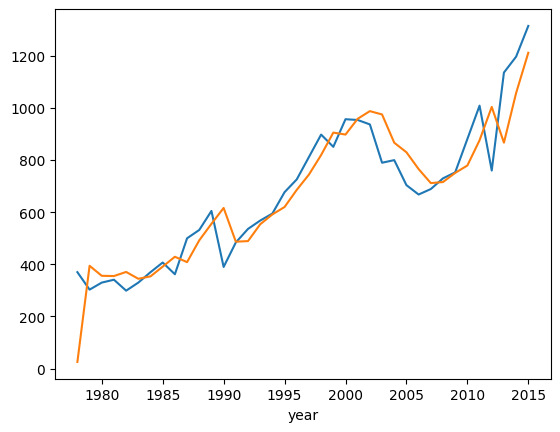

In [15]:
prediction = result4.get_prediction()
result4.data.orig_endog.plot(label='data', fig=fig)
prediction.predicted_mean.plot(fig=fig)

### 3. řada - Tučňák uzdičkový (Chinstrap)

Tato řada se již více podobá první analyzované řadě, nepozoruji ani trend, ani sezónnost.

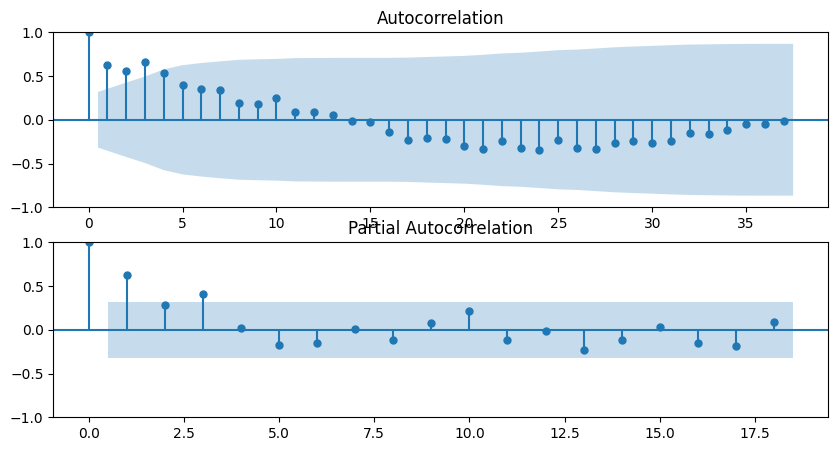

In [16]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Chinstrap breeding pairs'], lags=37, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Chinstrap breeding pairs'], lags=18, method='ywm', ax=ax2)

In [17]:
stepwise_fit = pm.auto_arima(df['Chinstrap breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='bic',
                             stepwise=True) 
stepwise_fit = pm.auto_arima(df['Chinstrap breeding pairs'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=0,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='aic',
                             stepwise=True) 

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=530.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=526.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=526.926, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=518.243, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=519.488, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=519.984, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=523.029, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=515.500, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=522.835, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : BIC=517.599, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=518.136, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=518.340, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : BIC=521.006, Time

Kritéria AIC i BIC se poprvé shodly, a to na modelu ARIMA(2,1,0). Jedná se tedy o třetí různý model.

In [18]:
model = ARIMA(df['Chinstrap breeding pairs'], order=(2,1,0), trend='n')
result = model.fit()
print(result.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Chinstrap breeding pairs   No. Observations:                   38
Model:                       ARIMA(2, 1, 0)   Log Likelihood                -252.333
Date:                      Sat, 17 Dec 2022   AIC                            510.667
Time:                              22:05:07   BIC                            515.500
Sample:                                   0   HQIC                           512.371
                                       - 38                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6511      0.169     -3.849      0.000      -0.983      -0.320
ar.L2         -0.5063      0.139     -3.649      0.000      -0.778      -0.234
sigm

C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kikij\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predikce:

<AxesSubplot:xlabel='year'>

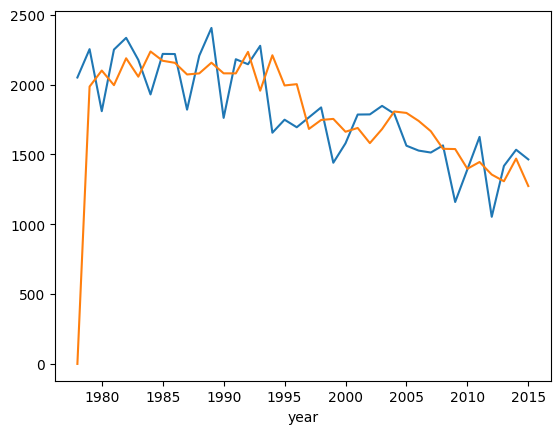

In [19]:
prediction = result.get_prediction()
result.data.orig_endog.plot(label='data', fig=fig)
prediction.predicted_mean.plot(fig=fig)

## Jak spolu souvisí počty napříč druhy?

In [20]:
df.corr()

,Adélie breeding pairs,Chinstrap breeding pairs,Gentoo breeding pairs
Adélie breeding pairs,1.000000,0.667295,-0.282687
Chinstrap breeding pairs,0.667295,1.000000,-0.659069
Gentoo breeding pairs,-0.282687,-0.659069,1.000000


- adélie + gentoo - nekorelují
- adélie + chinstrap - pozitivní lineární korelace
- chinstrap + gentoo - negativní lineární korelace

In [21]:
partial_corr(data=df, x='Chinstrap breeding pairs', y='Adélie breeding pairs', covar=['Gentoo breeding pairs'], method='pearson')

,n,r,CI95%,p-val
pearson,38,0.666732,"[0.44, 0.81]",0.000007


In [22]:
partial_corr(data=df, x='Gentoo breeding pairs', y='Chinstrap breeding pairs', covar=['Adélie breeding pairs'], method='pearson')

,n,r,CI95%,p-val
pearson,38,-0.658487,"[-0.81, -0.43]",0.000009


In [23]:
partial_corr(data=df, x='Adélie breeding pairs', y='Gentoo breeding pairs', covar=['Chinstrap breeding pairs'], method='pearson')

,n,r,CI95%,p-val
pearson,38,0.280474,"[-0.05, 0.55]",0.092678


Oproti lineárnímu korelačnímu koeficientu se v prvních dvou případech výsledky téměř neliší. U parciální korelace ve třetím případě došlo ke změně znaménka, stále se však jedná o tak malou hodnotu, abych mohla vyvodit, že data nekorelují.
Vzhledem ke stejnosti výsledků mohu tvrdit, že žádný z druhů na korelaci druhých dvou řad nemá vliv.

## Závěr

Ačkoliv ve všech třech případech vyjadřovaly časové řady počty tučňáků na jednom místě (ostrov Signy v Jižních Orknejích), ukázalo se, že není vhodné tyto řady modelovat pomocí stejného modelu. Výsledky také naznačují (při pohledu na počty samotné), že počty tučňáků uzdičkových mohou souviset s počty ostatních druhů tučňáků na ostrově.